# German traffic classification using convultion neural network

1. In this notebook we are going to classify german traffic signs using convolution neural network
2. We will learn about implementing convultion using mxnet.
3. The notebook assumes that you have fair understanding of convolution neural network.

In [1]:
#some imports along with mxnet
%matplotlib inline
import mxnet as mx
import numpy as np
import cv2
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

ImportError: No module named 'mxnet'

In [4]:
# Load pickled data
# we already have all the data pickled to file. This helps easy loading of train and test set
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

We are going to print few statistics of data. German traffic is a multi class classification problem.t There are 43 different classes of traffic sign in the dataset

In [5]:
### Statistics about the data
import numpy as np

# Number of training examples
n_train = len(X_train)

#Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))



print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print(y_train.shape)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
(39209,)


(39209, 3, 32, 32)


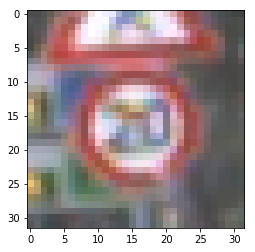

In [6]:
#rolled = np.rollaxis(X_train, 3,1) 
#reshape = np.reshape(rolled,(-1,3,32,32)) 
#print(rolled.shape)
#making sure the images are plotted correctly
#reshape = np.transpose(:,1,2,0)
plt.imshow(reshape[0].astype(np.uint8).transpose((1,2,0)))

In [7]:
#record the image size, number of channel (RGB) and classes
img_size = X_train[0].shape[0]
num_channels = X_train[0].shape[2]
num_classes = n_classes


The actual name of classes are given in separate csv file. We need to Load the csv file to map from label id to actual name


In [8]:
# The actual name of the classes are given in separate file. Here we load the csv file which allows mapping from classes/labels to 
# file name
import csv
def read_csv_and_parse():
    traffic_labels_dict ={}
    with open('signnames.csv') as f:
        reader = csv.reader(f)
        count = -1;
        for row in reader:
            count = count + 1
            if(count == 0):
                continue
            label_index = int(row[0])
            traffic_labels_dict[label_index] = row[1]
    return traffic_labels_dict
traffic_labels_dict = read_csv_and_parse()
print(traffic_labels_dict)

{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing for vehicles over 3.5 metric tons', 11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Vehicles over 3.5 metric tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve to the left', 20: 'Dangerous curve to the right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End of all speed and passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight o

Next , we will visualise the data and see the corresponding image and traffic sign label

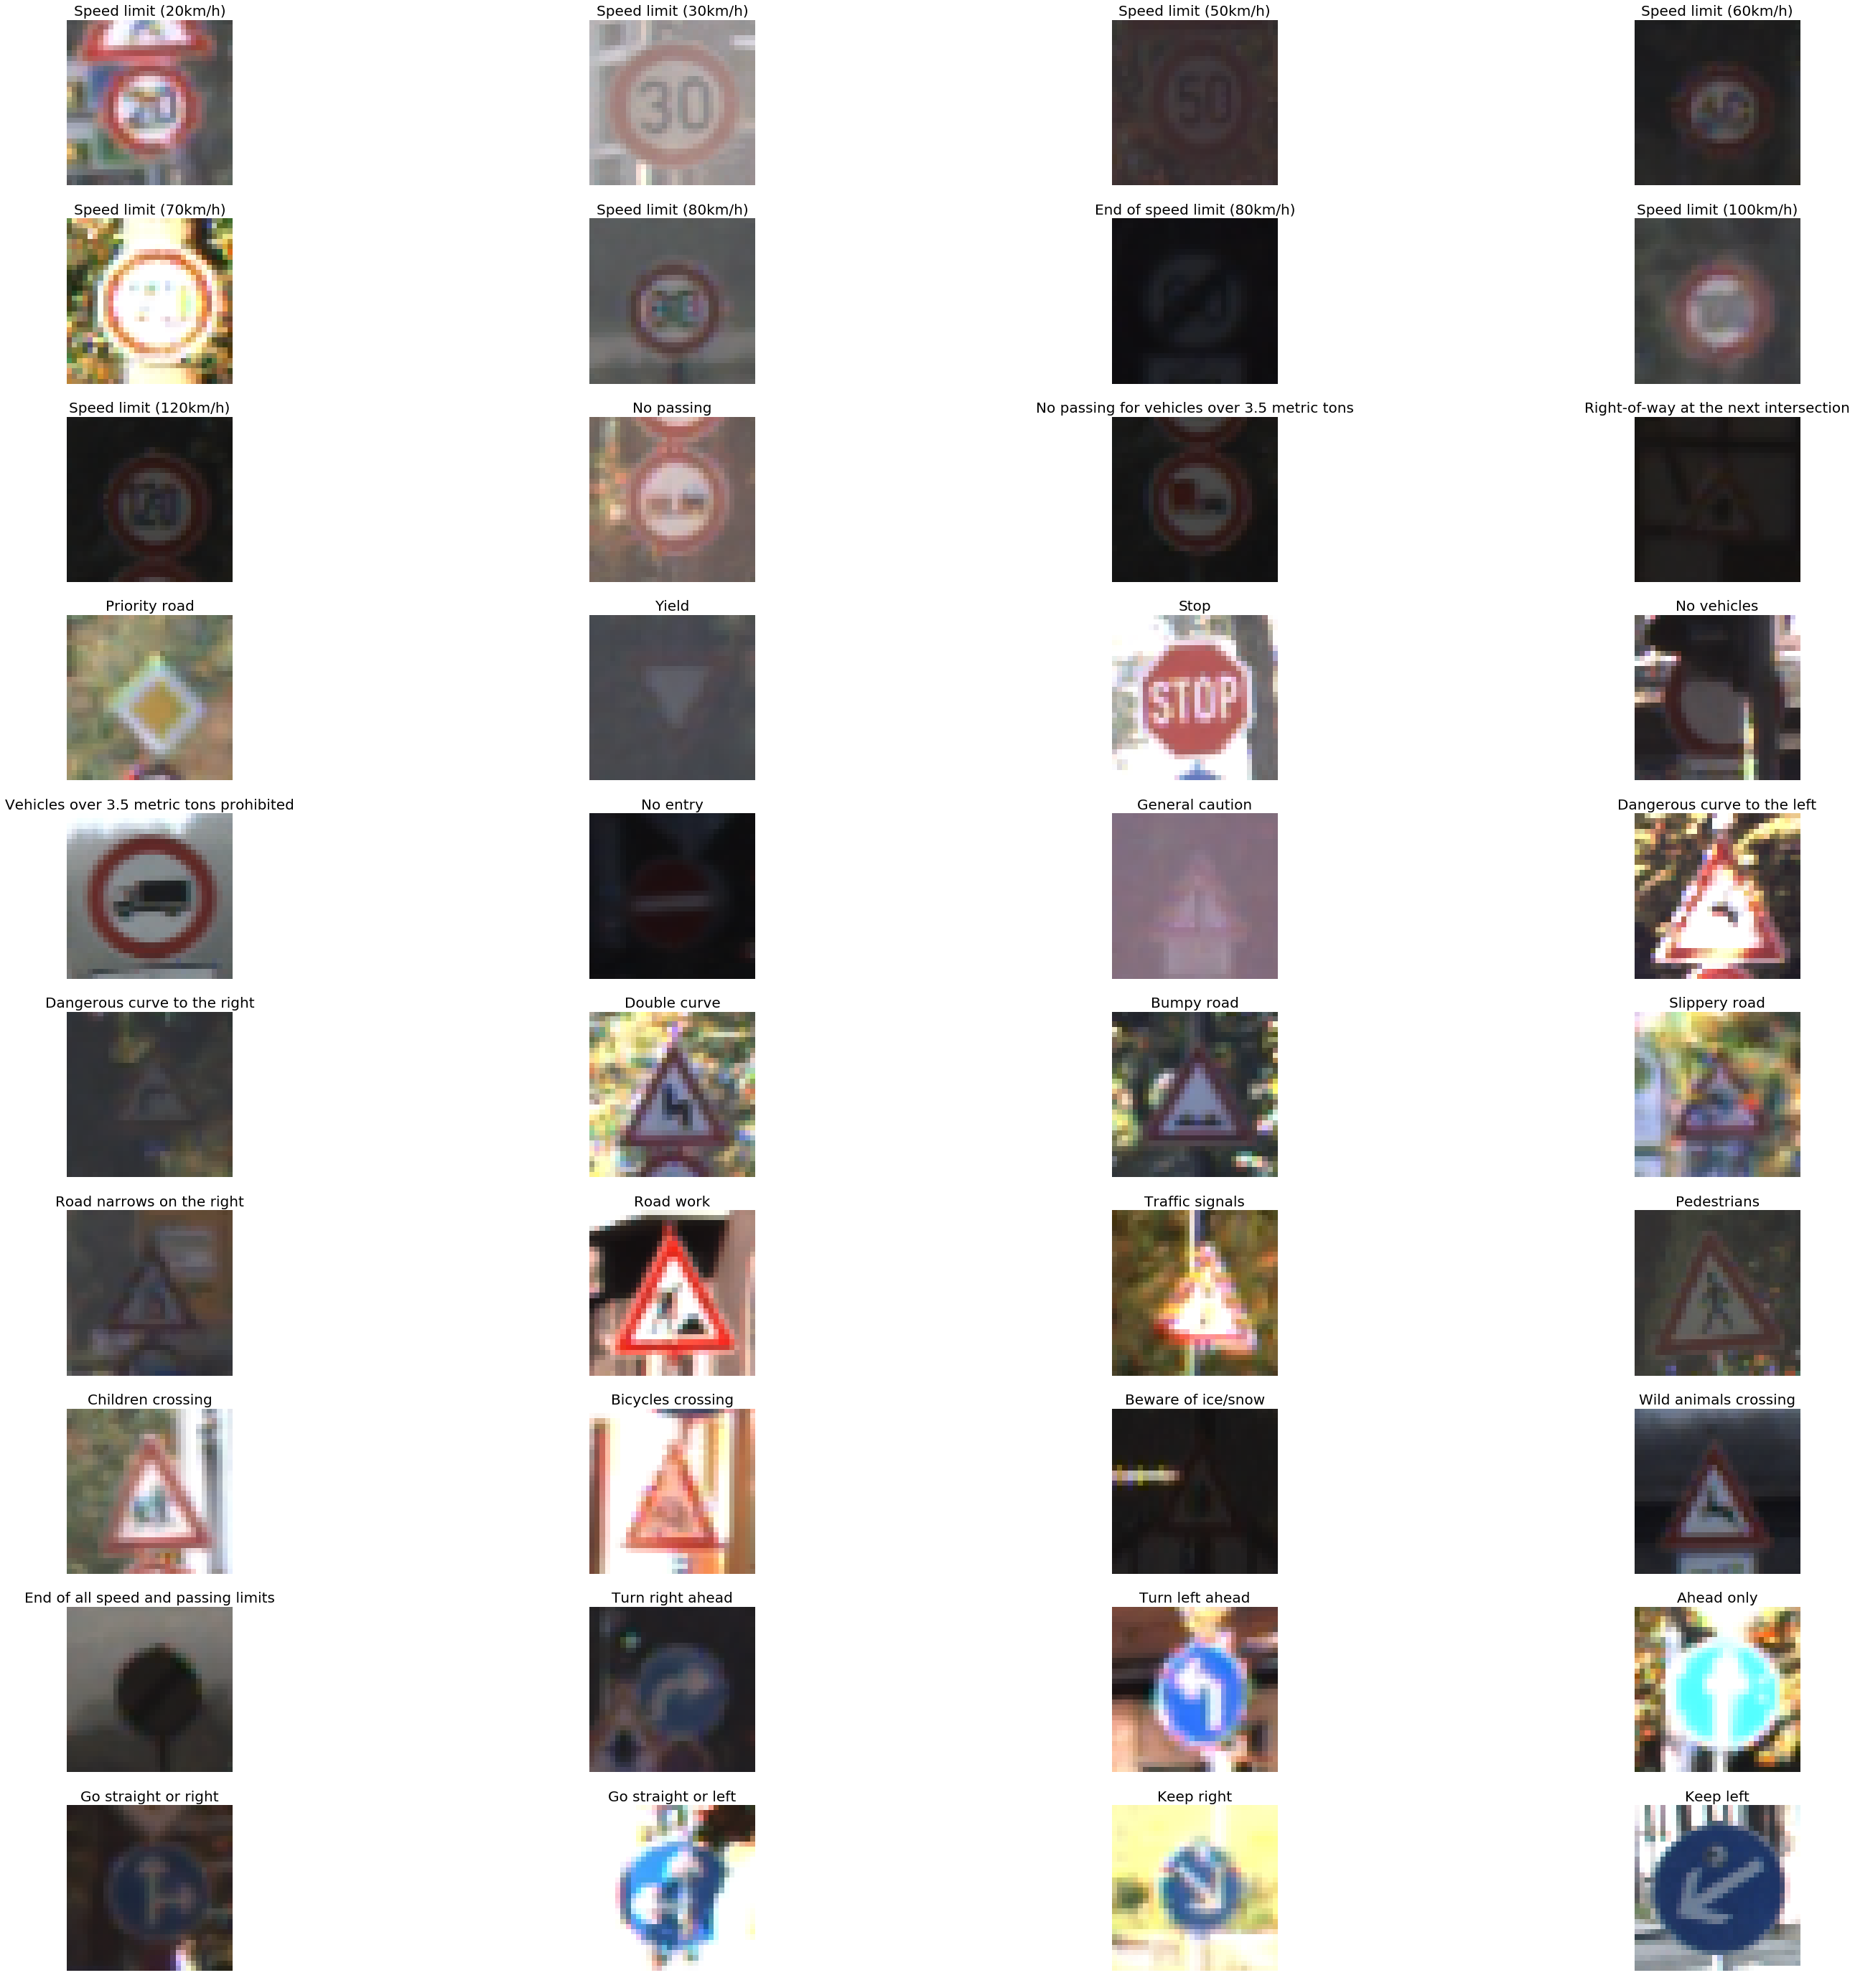

In [9]:
# Data exploration visualization
# This gives better understanding of the data

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
# Visualizations will be shown in the notebook.
%matplotlib inline

#This functions selects one image per class to plot
def get_images_to_plot(images, labels):
    selected_image = []
    idx = []
    for i in range(n_classes):
        selected = np.where(labels == i)[0][0]
        selected_image.append(images[selected])
        idx.append(selected)
    return selected_image,idx
 
# function to plot the images in a grid    
def plot_images(selected_image,row=5,col=10,idx = None):     
    count =0;
    f, axarr = plt.subplots(row, col,figsize=(50, 50))
   
    for i in range(row): 
         for j in range(col):
                if(count < len(selected_image)):
                    axarr[i,j].imshow(selected_image[count])
                    if(idx != None):
                        axarr[i,j].set_title(traffic_labels_dict[y_train[idx[count]]], fontsize=20)
                axarr[i,j].axis('off')
                count = count + 1
           
            

selected_image,idx = get_images_to_plot(X_train,y_train)
plot_images(selected_image,row=10,col=4,idx=idx)

## Above is the plot of various traffic sign along with the corresponding images

In [10]:
#count the number of data associated with each label. We can the data is not evenly distributed across the label
print(np.bincount(y_train))

[ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160  780
  630  420 1110 1200  210  360  330  390  510  270 1500  600  240  540  270
  450  780  240  689  420 1200  390  210 2070  300  360  240  240]


## we can clearly see the dataset is not balanced. For example there are 210 images with label 0 and 2220 images with label 1. This will cause convultion neural network to favor images with higher occurence(count)

In [2]:
# randomly translates the images (shifts the image)
# Generates additional data with translated image
# Image is input image and trans_range is range of translation
def random_trans(image, trans_range):
    rows,cols,_ = image.shape;
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    tr_y = trans_range * np.random.uniform() - trans_range / 2
    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    image_tr = cv2.warpAffine(image, Trans_M, (cols, rows))
    return image_tr


# Code for balancing dataset
def get_additional(count, label, X_train, y_train):
    selected = np.where(y_train == label)[0]
    counter = 0;
    m = 0;
    # just select the first element in selected labels
    X_mqp = X_train[selected[0]]
    X_mqp = X_mqp[np.newaxis, ...]
    while m < (len(selected)):
        aa =  X_train[selected[m]] # random_trans(X_train[selected[m]],20)
        # ignore the first element, since it already selected
        X_mqp = np.vstack([X_mqp, aa[np.newaxis, ...]])
        if (counter >= count):
            break
        if (m == (len(selected) - 1)):
            m = 0
        counter = counter + 1
        m = m + 1
    Y_mqp = np.full((len(X_mqp)), label, dtype='uint8')

    return X_mqp, Y_mqp

def balance_dataset(X_train_extra, Y_train_extra):
    hist = np.bincount(y_train)
    max_count = np.max(hist)
    for i in range(len(hist)):
        X_mqp, Y_mqp = get_additional(max_count - hist[i], i, X_train, y_train)
        X_train_extra = np.vstack([X_train_extra, X_mqp])
        Y_train_extra = np.append(Y_train_extra, Y_mqp)
        
    return X_train_extra,Y_train_extra

X_train_extra,Y_train_extra =reshape,y_train #balance_dataset(X_train,y_train)
print(Y_train_extra.shape)
print(X_train_extra.shape)

NameError: name 'reshape' is not defined

NameError: name 'train_img' is not defined

In [10]:
print(np.bincount(Y_train_extra))
#We can see now the dataset is balanced. The labels are equally distributed

[ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160  780
  630  420 1110 1200  210  360  330  390  510  270 1500  600  240  540  270
  450  780  240  689  420 1200  390  210 2070  300  360  240  240]


In [25]:
data = mx.symbol.Variable('data')
conv1 = mx.sym.Convolution(data=data, pad=(1,1), kernel=(3,3), num_filter=24, name="conv1")
relu1 = mx.sym.Activation(data=conv1, act_type="relu", name= "relu1")
#pool1 = mx.sym.Pooling(data=relu1, pool_type="max", kernel=(2,2), stride=(2,2),name="max_pool1")
# second conv layer
conv2 = mx.sym.Convolution(data=relu1, kernel=(3,3), num_filter=24, name="conv2", pad=(1,1))
relu2 = mx.sym.Activation(data=conv2, act_type="relu", name="relu2")
pool2 = mx.sym.Pooling(data=relu2, pool_type="max", kernel=(2,2), stride=(2,2),name="max_pool2")
#
conv3 = mx.sym.Convolution(data=pool2, kernel=(5,5), num_filter=64, name="conv3")
relu3 = mx.sym.Activation(data=conv3, act_type="relu", name="relu3")
pool3 = mx.sym.Pooling(data=relu3, pool_type="max", kernel=(2,2), stride=(2,2),name="max_pool3")
# first fullc layer
flatten = mx.sym.Flatten(data=pool3)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500, name="fc1")
relu3 = mx.sym.Activation(data=fc1, act_type="relu" , name="relu3")
# second fullc
fc2 = mx.sym.FullyConnected(data=relu3, num_hidden=43,name="final_fc")
# softmax loss
mynet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

In [26]:
mynet.list_arguments()

['data',
 'conv1_weight',
 'conv1_bias',
 'conv2_weight',
 'conv2_bias',
 'conv3_weight',
 'conv3_bias',
 'fc1_weight',
 'fc1_bias',
 'final_fc_weight',
 'final_fc_bias',
 'softmax_label']

In [27]:
import mxnet as mx


batch_size = 64
X_train_extra_float = X_train_extra.astype('float32')
X_train_extra_norm = X_train_extra_float / 255.0

X_test_float = X_test.astype('float32')
X_test_norm = X_test / 255.0 ;
print(X_train_extra_norm[0].shape)

train_iter =mx.io.NDArrayIter(X_train_extra_norm, Y_train_extra, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_test_norm, y_test, batch_size)

for batch in train_iter:
    print(batch.data[0].shape)
    break;
    


print(X_train_extra.shape)
print(X_test.shape)
print(Y_train_extra.shape)
print(y_test.shape)

(3, 32, 32)
(64, 3, 32, 32)
(39209, 3, 32, 32)
(12630, 32, 32, 3)
(39209,)
(12630,)


In [28]:
adam = mx.optimizer.create('adam', learning_rate=.001)

In [29]:
model = mx.model.FeedForward(
    ctx = mx.gpu(0),     # use GPU 0 for training, others are same as before
    symbol = mynet,       
    num_epoch = 10, 
    learning_rate = 0.1)
model.fit(
    X=train_iter,  
    batch_end_callback = mx.callback.Speedometer(batch_size,64)
)

INFO:root:Start training with [gpu(0)]
INFO:root:Epoch[0] Batch [64]	Speed: 3172.19 samples/sec	Train-accuracy=0.005127
INFO:root:Epoch[0] Batch [128]	Speed: 3197.60 samples/sec	Train-accuracy=0.004395
INFO:root:Epoch[0] Batch [192]	Speed: 3205.13 samples/sec	Train-accuracy=0.006592
INFO:root:Epoch[0] Batch [256]	Speed: 3201.68 samples/sec	Train-accuracy=0.004883
INFO:root:Epoch[0] Batch [320]	Speed: 3203.24 samples/sec	Train-accuracy=0.005127
INFO:root:Epoch[0] Batch [384]	Speed: 3168.67 samples/sec	Train-accuracy=0.004150
INFO:root:Epoch[0] Batch [448]	Speed: 3182.52 samples/sec	Train-accuracy=0.005615
INFO:root:Epoch[0] Batch [512]	Speed: 3213.50 samples/sec	Train-accuracy=0.005371
INFO:root:Epoch[0] Batch [576]	Speed: 3199.92 samples/sec	Train-accuracy=0.006592
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=12.314
INFO:root:Epoch[1] Batch [64]	Speed: 3246.54 samples/sec	Train-accuracy=0.005127
INFO:root:Epoch[1] Batch [128]	Speed: 3205.27 samples/sec	Train-

In [17]:
a = np.mgrid[0:2, 0:2]

In [18]:
print(a)

[[[0 0]
  [1 1]]

 [[0 1]
  [0 1]]]


In [19]:
a.reshape(4,2)

array([[0, 0],
       [1, 1],
       [0, 1],
       [0, 1]])

In [39]:
p=[0.2, 0.2, 0.2, 0.2, 0.2]
world=['green', 'red', 'red', 'green', 'green']
Z = 'red'
pHit = 0.6
pMiss = 0.2

def sense(p, Z):
    for color,prob,idx in zip(world,p,enumerate(p)):
        if color == Z:
            p[idx[0]] = prob * pHit
        else:
             p[idx[0]] = prob * pMiss
        print(idx)
    return p

print (sense(p,Z))

(0, 0.2)
(1, 0.2)
(2, 0.2)
(3, 0.2)
(4, 0.2)
[0.04000000000000001, 0.12, 0.12, 0.04000000000000001, 0.04000000000000001]


In [30]:
ints = [8, 23, 45, 12, 78]
for x,y in enumerate(ints):
    print (x,y)

0 8
1 23
2 45
3 12
4 78


In [ ]:
U = U % len(p)
    q = p[-U:] + p[:-U]

In [45]:
p = [0,1,0,0,0]
print(p[-1:])

[0]


In [ ]:
p[]